In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/GSET25")
!pwd

/content/drive/MyDrive/GSET25


In [ ]:
!pip install monai-generative
!pip install lpips
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=3c64ade60bc3f73d7b776364646c81ec687506edc163294f74e5c2aeb40b2612
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
import numpy as np
from medmnist import BreastMNIST,  BloodMNIST
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor



class MyMedMNIST(BloodMNIST):
    def __getitem__(self, item):
        img, _ = super().__getitem__(item)
        return img

if __name__ == '__main__':
    image_size = 64
    train_data = MyMedMNIST(split="train", download=True, size=image_size, root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(train_data)
    # indices = list(range(4000))
    # train_data = Subset(train_data, indices)
    print(len(train_data))

    val_data = MyMedMNIST(split="val", download=True, size=image_size, root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(val_data)
    # val_data = Subset(val_data, list(range(1000)))
    print(len(val_data))

    test_data = MyMedMNIST(split="test", download=True, size=image_size,root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(test_data)
    # test_data = Subset(test_data, list(range(500)))
    print(len(test_data))

    train_loader = DataLoader(
        dataset=train_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )
    val_loader = DataLoader(
        dataset=val_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )

Using downloaded and verified file: /content/drive/MyDrive/GSET25/bloodmnist_64.npz
Dataset MyMedMNIST of size 64 (bloodmnist_64)
    Number of datapoints: 11959
    Root location: /content/drive/MyDrive/GSET25
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution

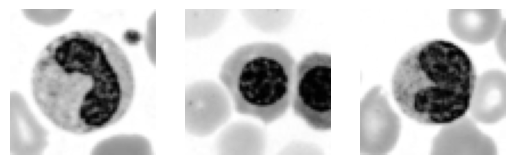

In [ ]:
check_data = next(iter((train_loader)))
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data[image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [ ]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 179MB/s]
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle mod

In [ ]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=3, out_channels=3)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [ ]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

<ipython-input-10-a3c26ff30d0e>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = torch.cuda.amp.GradScaler()
<ipython-input-10-a3c26ff30d0e>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_d = torch.cuda.amp.GradScaler()


In [ ]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda'):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with torch.amp.autocast('cuda'):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch.to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()
del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 9: 100%|███████████████████| 94/94 [01:13<00:00,  1.29it/s, recons_loss=0.0263, gen_loss=0, disc_loss=0]
<ipython-input-11-17dd68b35106>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


epoch 10 val loss: 0.0227


Epoch 19: 100%|██████████| 94/94 [01:16<00:00,  1.23it/s, recons_loss=0.0206, gen_loss=0.367, disc_loss=0.272]


epoch 20 val loss: 0.0211


Epoch 29: 100%|██████████| 94/94 [01:16<00:00,  1.24it/s, recons_loss=0.0191, gen_loss=0.301, disc_loss=0.232]


epoch 30 val loss: 0.0182


Epoch 39: 100%|███████████| 94/94 [01:16<00:00,  1.23it/s, recons_loss=0.018, gen_loss=0.277, disc_loss=0.244]


epoch 40 val loss: 0.0187


Epoch 49: 100%|██████████| 94/94 [01:16<00:00,  1.23it/s, recons_loss=0.0172, gen_loss=0.275, disc_loss=0.246]


epoch 50 val loss: 0.0171


Epoch 59: 100%|██████████| 94/94 [01:16<00:00,  1.23it/s, recons_loss=0.0165, gen_loss=0.277, disc_loss=0.249]


epoch 60 val loss: 0.0165


Epoch 69: 100%|████████████| 94/94 [01:16<00:00,  1.23it/s, recons_loss=0.016, gen_loss=0.28, disc_loss=0.245]


epoch 70 val loss: 0.0156


Epoch 76:  87%|██████████▍ | 82/94 [01:06<00:09,  1.24it/s, recons_loss=0.016, gen_loss=0.272, disc_loss=0.25]

In [ ]:
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

In [ ]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    schedule="linear_beta",
    beta_start=0.0015,
    beta_end=0.0195
)

In [ ]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data.to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)


In [ ]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [ ]:
from torch import nn
class ChannelReducer(nn.Module):
    def __init__(self):
        super(ChannelReducer, self).__init__()
        self.conv = nn.Conv2d(16, 3, kernel_size=1)  # Sử dụng tích chập 1x1 để giảm số kênh

    def forward(self, x):
        return self.conv(x)

# Khởi tạo bộ giảm kênh
channel_reducer = ChannelReducer().to(device)

In [ ]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 50
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch.to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()

### Plot learning curves

In [ ]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

In [ ]:
list_inter = []
for i in range(100):
  unet.eval()
  scheduler.set_timesteps(num_inference_steps=1000)
  noise = torch.randn((1, 3, 16,16))
  noise = noise.to(device)
  with torch.no_grad():
      image, intermediates = inferer.sample(
          input_noise=noise,
          diffusion_model=unet,
          scheduler=scheduler,
          save_intermediates=True,
          intermediate_steps=100,
          autoencoder_model=autoencoderkl,
      )
  list_inter.append(intermediates)

In [ ]:
for intermediates in list_inter:
  decoded_images = []
  for image in intermediates:
      with torch.no_grad():
          decoded_images.append(image)
  plt.figure(figsize=(10, 12))
  chain = torch.cat(decoded_images, dim=-1)
  plt.style.use("default")
  plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
  plt.tight_layout()
  plt.axis("off")

In [ ]:
from PIL import Image

os.makedirs("src", exist_ok=True)
selected_images = []
for i, images in enumerate(val_loader):
    if len(selected_images) >= 10:
        break
    for j in range(images.size(0)):
        selected_images.append(images[j])
        if len(selected_images) == 10:
            break
for i, image in enumerate(selected_images):
    image = image[0]  # Assuming the first channel is what you want
    image = image.cpu().numpy()
    image = (image * 255).astype(np.uint8)
    pil_image = Image.fromarray(image, mode="L")
    pil_image.save(f"src/src_blood_pic_{i}.jpg")

In [ ]:
os.makedirs("gen", exist_ok=True)
i = 0

for intermediates in list_inter:
    image = intermediates[-1].squeeze(0)  # This removes the batch dimension, resulting in (3, 64, 64)
    # Convert tensor to a numpy array and move the channel dimension for PIL
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)  # Scale the values to [0, 255]
    pil_image = Image.fromarray(image, mode="RGB")  # Create a PIL image in RGB mode
    pil_image.save(f"gen/gen_blood_pic_{i}.jpg")  # Save the image file
    i += 1

In [ ]:
torch.save(unet.state_dict(), '/content/drive/MyDrive/GSET25/unet_moon_model_blood.pth')
torch.save(scheduler.state_dict(), '/content/drive/MyDrive/GSET25/scheduler_moon_model_blood.pth')
torch.save(autoencoderkl.state_dict(), '/content/drive/MyDrive/GSET25/autoencoder_moon_model_blood.pth')